# Spectral analysis of NEMO surface tracer PCA results

Figs. 8 and S3 from:

>B. Moore-Maley and S. E. Allen: Wind-driven upwelling and surface nutrient delivery in a semi-enclosed coastal sea, Ocean Sci., 2022.

Description:

Power spectral density (PSD) and spectral coherence with along-axis, HRDPS wind stress calculated from the principal component (PC) loadings of the four dominant surface tracer PCA modes. The phase lag associated with coherence is also reported.

***

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy import signal
from tqdm.notebook import tqdm
from roman import toRoman

import tools

%matplotlib inline

In [2]:
plt.rcParams['font.size'] = 12

***

### Load data

In [3]:
# Get hardcoded seasonal index
seasonbounds, seasonindex = tools.get_seasonal_indices()

# Load NEMO aggregation results
with xr.open_dataset('/path/to/files/MooreMaleyAllenOS2022_modelfields.nc') as ds:
    tau_along = ds.tau_along.values[seasonindex]

# PCA results
ds = {var: xr.open_dataset(f'/path/to/files/{var}_PCA.nc') for var in ('temperature', 'nitrate')}

***

### Spectral analysis functions

The following functions are used to calculate the power spectral density and spectral coherence of the PC loadings time series using the Multitaper Method. The tapers are generated as Discrete Prolate Spheroidal Sequences (DPSS). A first order autoregressive (AR1) process generator fit to an input PC loadings array is also defined. The following references are used.

   * D. Wilks. Statistical Methods in the Atmospheric Sciences, 4th Ed., Elsevier, Amsterdam, Netherlands, https://doi.org/10.1016/C2017-0-03921-6, 2020.

   * D. B. Percival and A. T. Walden. Spectral Analysis for Physical Applications, Cambridge University Press, Cambridge, UK, https://doi.org/10.1017/CBO9780511622762, 1993.

   * D. J. Thomson. Spectrum estimation and harmonic analysis, Proceedings of the IEEE, 70(9), 1055-1096, https://doi.org/10.1109/PROC.1982.12433, 1982.

In [4]:
def get_AR1_params(x):
    """Get AR1 parameters from timeseries.
    From D. Wilks. Statistical Methods in the Atmospheric Sciences,
    4th Ed., Elsevier, Amsterdam, Netherlands,
    https://doi.org/10.1016/C2017-0-03921-6, 2020.
    """
    
    # Determine AR1 fit parameters
    x_mean = x.mean()
    r_1 = sum((x[:-1] - x_mean) * (x[1:] - x_mean)) / sum((x - x_mean)**2) # - Eq. 3.38
    phi = r_1  # ------------------------------------------------------------- Eq. 10.18
    sigma = np.sqrt((1 - phi**2) * np.var(x))  # ----------------------------- Eq. 10.21
    
    return phi, sigma


def build_AR1(n, phi, sigma, cutoff):
    """Build AR1 timeseries from parameters and apply highpass filter.
    From D. Wilks. Statistical Methods in the Atmospheric Sciences,
    4th Ed., Elsevier, Amsterdam, Netherlands,
    https://doi.org/10.1016/C2017-0-03921-6, 2020.
    """
    
    # Build red-noise array (Eq. 10.16)
    x = np.empty(n)
    for i in range(0, n-1):
        x[i+1] = phi * x[i] + np.random.normal(0, sigma)
    
    # Apply same highpass filter as used for PCs and calc fft
    x = x - tools.lowpass(x, cutoff)
    
    return x


def calc_PSD(x, n, tapers, weights):
    """Calculate the multitaper ensemble fft and power spectral density
    of a data record x over a transformation length n. n should ideally
    be chosen as some value 2^k larger than the data record length, x will
    be zero-padded. x will be tapered and the ensemble average will be
    weighted using weights.
    From D. B. Percival and A. T. Walden. Spectral Analysis for Physical
    Applications, Cambridge University Press, Cambridge, UK,
    https://doi.org/10.1017/CBO9780511622762, 1993.
    """
    
    # Calculate multitaper fft and PSD
    fft = np.fft.rfft(tapers * (x - x.mean()), n) # ---------------------- Eq. 333
    PSD = (weights[:, None] * abs(fft)**2).sum(axis=0) / weights.sum() # - Eq. 369a
    
    return PSD, fft


def calc_coherence(x, y, n, tapers, weights):
    """Calculate the multitaper ensemble spectral coherence between
    data records x and y over transformation length n. The tapers
    are used to calculate the ensemble fft and the weights are used
    for the weighted averages. The phase angle in radians between
    x and y is also returned.
    From D. J. Thomson. Spectrum estimation and harmonic analysis,
    Proceedings of the IEEE, 70(9), 1055-1096,
    https://doi.org/10.1109/PROC.1982.12433, 1982.
    """
    
    # Calculate PSD
    Pxx, fftx = calc_PSD(x, n, tapers, weights)
    Pyy, ffty = calc_PSD(y, n, tapers, weights)
    
    # Calculate multitaper coherence and phase angle
    Pxy = np.sum(weights[:, None] * fftx * np.conj(ffty), axis=0) / np.sum(weights) # - Eq. 14.1
    Cxy = abs(Pxy)**2 / (Pxx * Pyy) # ------------------------------------------------- Eq. 14.2
    angle = np.angle(Pxy)
    
    return Cxy, angle


def calc_spectra(freq, x, y, n, tapers, weights, NW=[2.5, 15], fs=24):
    """Wrapper for calc_PSD and calc_coherence.
    Normalizes PSD and calculates lag in days from angle.
    """
    
    bw = fs / n
    PSD, _ = calc_PSD(y, n, tapers[NW[0]], weights[NW[0]])
    Cxy, angle = calc_coherence(x, y, n, tapers[NW[1]], weights[NW[1]])
    lag = abs(angle / (2 * np.pi * np.insert(freq[1:], 0, np.nan)))
    
    return PSD / PSD.sum() / bw, Cxy, lag

***

### Calculate and plot spectra

Define parameters and tapers

In [5]:
# Spectral analysis parameters
n = len(ds['nitrate']['B'][:, 1])  # -------------- Data record length
fs = 24  # ---------------------------------------- Sampling frequency [d-1]
cutoff = 1235  # ---------------------------------- Blackman window length
nfft = 2**int(np.ceil(np.log2(n))) # -------------- Optimize fft transformation length as 2^k
bw = fs / nfft  # --------------------------------- Frequency domain bandwidth [d-1]
freq = np.linspace(0, int(fs/2), int(nfft/2+1)) # - Frequency array

# Generate tapers
tapers, weights = {}, {}
for NW in [2.5, 15]:
    tapers[NW], weights[NW] = signal.windows.dpss(n, NW, int(2*NW), return_ratios=True)

Determine confidence intervals as 99th percentiles of AR1 and white noise coherence.

In [6]:
# Build 1000 AR1 and white noise realizations of length n
phi, sigma = get_AR1_params(ds['nitrate']['B'][:, 1].values)
AR1, Cww = [], []
for k in tqdm(range(0, 1000)):
    
    # AR1
    x = build_AR1(n, phi, sigma, cutoff)
    PSD, _ = calc_PSD(x, nfft, tapers[2.5], weights[2.5])
    AR1.append(PSD)
    
    # White noise coherence
    x, y = np.random.normal(0, 1, size=n), np.random.normal(0, 1, size=n)
    Cxy, _ = calc_coherence(x, y, nfft, tapers[15], weights[15])
    Cww.append(Cxy)

# Find the AR1 99th percentile and filter/normalize for plotting
AR1 = np.vstack(AR1)
AR199 = np.percentile(AR1, 99, axis=0)
AR199 = tools.lowpass(AR199, 25) / AR1.mean(axis=0).sum() / bw

# Find the white noise coherence 99th percentile
C99 = np.percentile(np.hstack(Cww), 99)

  0%|          | 0/1000 [00:00<?, ?it/s]

Power spectral density, coherence and lag for Temperate mode I and Nitrate modes 1-3 (Fig. 8)

Text(0.5, 0, 'Frequency [d$^{-1}$]')

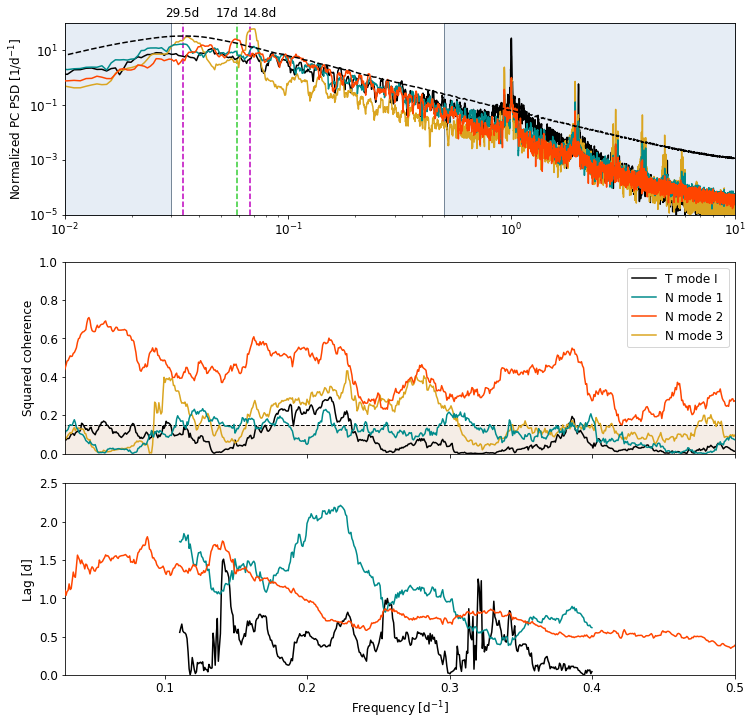

In [7]:
# Make figure
fig, axs = plt.subplots(3, 1, figsize=(12, 12), gridspec_kw={'hspace': 0.2})
xlims = [(0.01, 10.0), (0.03, 0.5), (0.03, 0.5)]
ylims = [(0.00001, 100), (0, 1), (0, 2.5)]
ylabels = ['Normalized PC PSD [1/d$^{-1}$]', 'Squared coherence', 'Lag [d]']

# Shade frequencies outside coherence region
for d, x, color in zip([14.8, 17, 29.5], [0.265, 0.225, 0.15], ['m', 'limegreen', 'm']):
    axs[0].plot([1/d, 1/d], ylims[0], '--', color=color, zorder=0)
    axs[0].text(x, 1.03, f'{str(d)}d', transform=axs[0].transAxes)
for x in np.array(xlims).T:
    axs[0].fill_betweenx(ylims[0], [x[0], x[0]], x[1], fc=[0.9, 0.93, 0.96], ec='lightslategray', ls='-', zorder=0)

# Index for plotting only coherent lag frequencies
lagindex = np.array([0.11 < f < 0.4 for f in freq])

# Plot T mode
PSD, Cxy, lag = calc_spectra(freq, tau_along, ds['temperature']['B'][:, 0].values, nfft, tapers, weights)
axs[0].plot(freq, PSD, 'k-', zorder=1)
axs[1].plot(freq, Cxy, 'k-', zorder=1, label='T mode I')
axs[2].plot(freq[lagindex], lag[lagindex], 'k-', zorder=1)

# Plot N modes
for mode, color, zorder in zip(range(3), ['darkcyan', 'orangered', 'goldenrod'], [2, 3, 1]):
    PSD, Cxy, lag = calc_spectra(freq, tau_along, -ds['nitrate']['B'][:, mode].values, nfft, tapers, weights)
    axs[0].plot(freq, PSD, color=color, zorder=zorder)
    axs[1].plot(freq, Cxy, color=color, zorder=zorder, label=f'N mode {mode+1}')
    if mode < 2:
        index = lagindex if mode == 0 else slice(None)
        axs[2].plot(freq[index], lag[index], color=color, zorder=zorder)

# Plot 99th percentiles of AR1 and white noise coherence
axs[0].plot(freq, AR199, 'k--', zorder=3)
axs[1].fill_between(freq[[0, -1]], [C99, C99], fc=[0.96, 0.93, 0.9], ec='k', ls='--', zorder=0)

# Formatting
for ax, xlim, ylim, ylabel in zip(axs, xlims, ylims, ylabels):
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_ylabel(ylabel)
axs[0].set_xscale('log')
axs[0].set_yscale('log')
pos = axs[1].get_position()
axs[1].set_position([pos.x0, pos.y0-0.01, pos.width, pos.height])
axs[1].xaxis.set_ticklabels('')
axs[1].legend()
axs[2].set_xlabel('Frequency [d$^{-1}$]')

First five PC PSD spectra (Fig. S3)

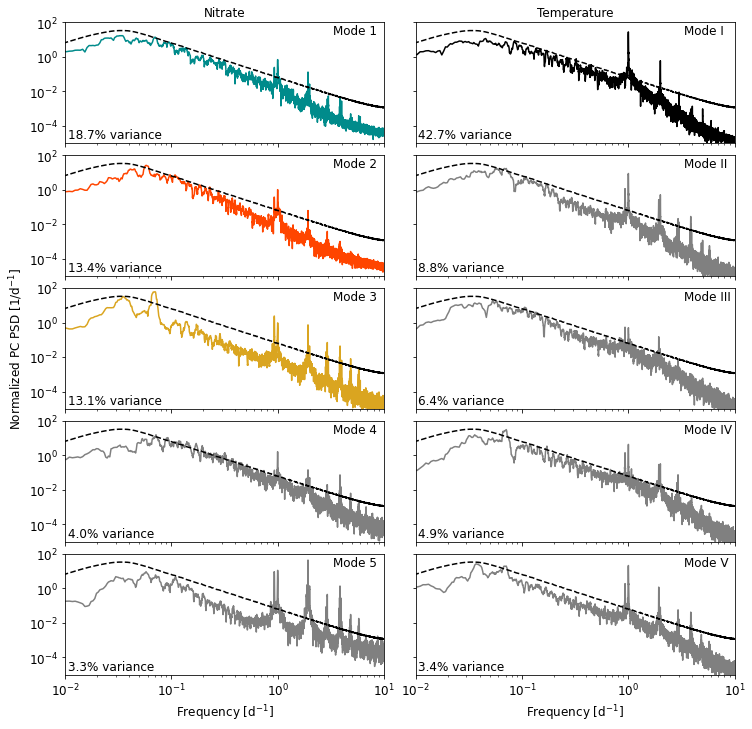

In [8]:
# Make figure and plotting params
fig, axs = plt.subplots(5, 2, figsize=(12, 12), gridspec_kw={'wspace': 0.1, 'hspace': 0.1})
axs[2, 0].set_ylabel('Normalized PC PSD [1/d$^{-1}$]')

# Loop through panels
for col, var in zip(axs.T, ['nitrate', 'temperature']):
    for ax, mode, color in zip(col, range(5), ['darkcyan', 'orangered', 'goldenrod', 'gray', 'gray']):
        if var == 'temperature': c = 'k' if mode == 0 else 'gray'
        else: c = color
        PSD, _ = calc_PSD(ds[var]['B'][:, mode].values, nfft, tapers[2.5], weights[2.5])
        ax.plot(freq, PSD / PSD.sum() / bw, color=c)
        ax.plot(freq, AR199, 'k--')
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlim([0.01, 10.0])
        ax.set_ylim([0.00001, 100])
        ax.yaxis.set_ticks([0.0001, 0.01, 1, 100])
        if var == 'temperature': ax.yaxis.set_ticklabels('')
        if mode == 0: ax.set_title(var.capitalize(), fontsize=12)
        if mode < 4: ax.xaxis.set_ticklabels('')
        else: ax.set_xlabel('Frequency [d$^{-1}$]')
        m = toRoman(mode + 1) if var == 'temperature' else mode + 1
        variance = ds[var]['var_rot'][mode].values * 100
        ax.text(0.84, 0.9, f"Mode {m}", transform=ax.transAxes)
        ax.text(0.008, 0.04, f"{variance:.01f}% variance", transform=ax.transAxes)